In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import optuna
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
train_csv = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test_csv = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

In [3]:
test_csv.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [4]:
train_csv.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [3]:
def split_group(df):
    new_df = df.copy()
    new_df.insert (1, "PassengerGroup", new_df["PassengerId"])
    new_df["PassengerGroup"] = new_df["PassengerGroup"].str[5:]
    return new_df

In [4]:
def split_cabin(df):
    new_df = df.copy()
    split_df = new_df['Cabin'].str.split('/', expand=True)
    new_df.insert(3, 'Side', split_df[2])     
    new_df.insert(3, 'Deck', split_df[0])
    new_df = new_df.drop(columns="Cabin")
    return new_df

In [21]:
def get_df(csv):
    num_cols = ['ShoppingMall','FoodCourt','RoomService','Spa','VRDeck','Age']
    cat_cols = ['CryoSleep','Deck','Side','VIP','HomePlanet','Destination',"PassengerGroup"]
    transported=['Transported']
    cat_imp = SimpleImputer(strategy='most_frequent')
    imputer = KNNImputer(n_neighbors=2)
    
    explore_DF = csv.copy()
    explore_DF = split_group(explore_DF)
    explore_DF = split_cabin(explore_DF)
    explore_DF[num_cols] = pd.DataFrame(imputer.fit_transform(explore_DF[num_cols]),columns=num_cols)
    explore_DF[cat_cols] = pd.DataFrame(cat_imp.fit_transform(explore_DF[cat_cols]),columns=cat_cols)
    explore_DF = explore_DF.drop(columns=["PassengerId", "Name"])
    
    explore_DF['Age_group'] = 0
    explore_DF.loc[explore_DF['Age']  <= 10, 'Age_group'] = 1
    explore_DF.loc[(explore_DF['Age'] > 10) & (explore_DF['Age'] <= 20), 'Age_group']=2
    explore_DF.loc[(explore_DF['Age'] > 20) & (explore_DF['Age'] <= 30), 'Age_group']=3
    explore_DF.loc[(explore_DF['Age'] > 30) & (explore_DF['Age'] <= 50), 'Age_group']=4
    explore_DF.loc[(explore_DF['Age'] > 50) & (explore_DF['Age'] <= 60), 'Age_group']=5
    explore_DF.loc[(explore_DF['Age'] > 60) & (explore_DF['Age'] <= 70), 'Age_group']=6
    explore_DF.loc[explore_DF['Age']  > 70, 'Age_group'] = 7
    
    
    ohe = OneHotEncoder (handle_unknown='ignore',sparse_output = False)
    temp = pd.DataFrame(ohe.fit_transform(explore_DF[cat_cols]),columns=ohe.get_feature_names_out())
    explore_DF = explore_DF.drop(cat_cols,axis=1)
    explore_DF = pd.concat([explore_DF,temp],axis=1)
    
    return explore_DF

In [23]:
trainDF = get_df(train_csv)

In [10]:
trainDF.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        8693 non-null   float64
 1   RoomService                8693 non-null   float64
 2   FoodCourt                  8693 non-null   float64
 3   ShoppingMall               8693 non-null   float64
 4   Spa                        8693 non-null   float64
 5   VRDeck                     8693 non-null   float64
 6   Transported                8693 non-null   bool   
 7   Age_group                  8693 non-null   int64  
 8   CryoSleep_False            8693 non-null   float64
 9   CryoSleep_True             8693 non-null   float64
 10  Deck_A                     8693 non-null   float64
 11  Deck_B                     8693 non-null   float64
 12  Deck_C                     8693 non-null   float64
 13  Deck_D                     8693 non-null   float

In [120]:
trainDF.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Age_group,CryoSleep_False,CryoSleep_True,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,PassengerGroup_01,PassengerGroup_02,PassengerGroup_03,PassengerGroup_04,PassengerGroup_05,PassengerGroup_06,PassengerGroup_07,PassengerGroup_08
0,39.0,0.0,0.0,0.0,0.0,0.0,False,5,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0,True,4,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,False,6,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,False,5,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,16.0,303.0,70.0,151.0,565.0,2.0,True,3,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


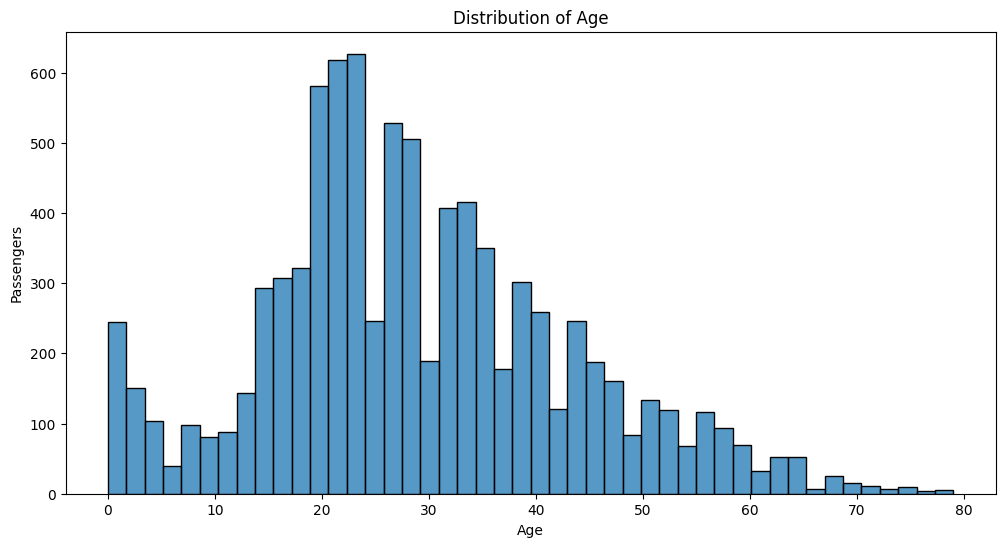

In [21]:
plt.figure(figsize=(12,6))

sns.histplot(trainDF, x='Age')

plt.ylabel('Passengers')
plt.title('Distribution of Age')

plt.show()

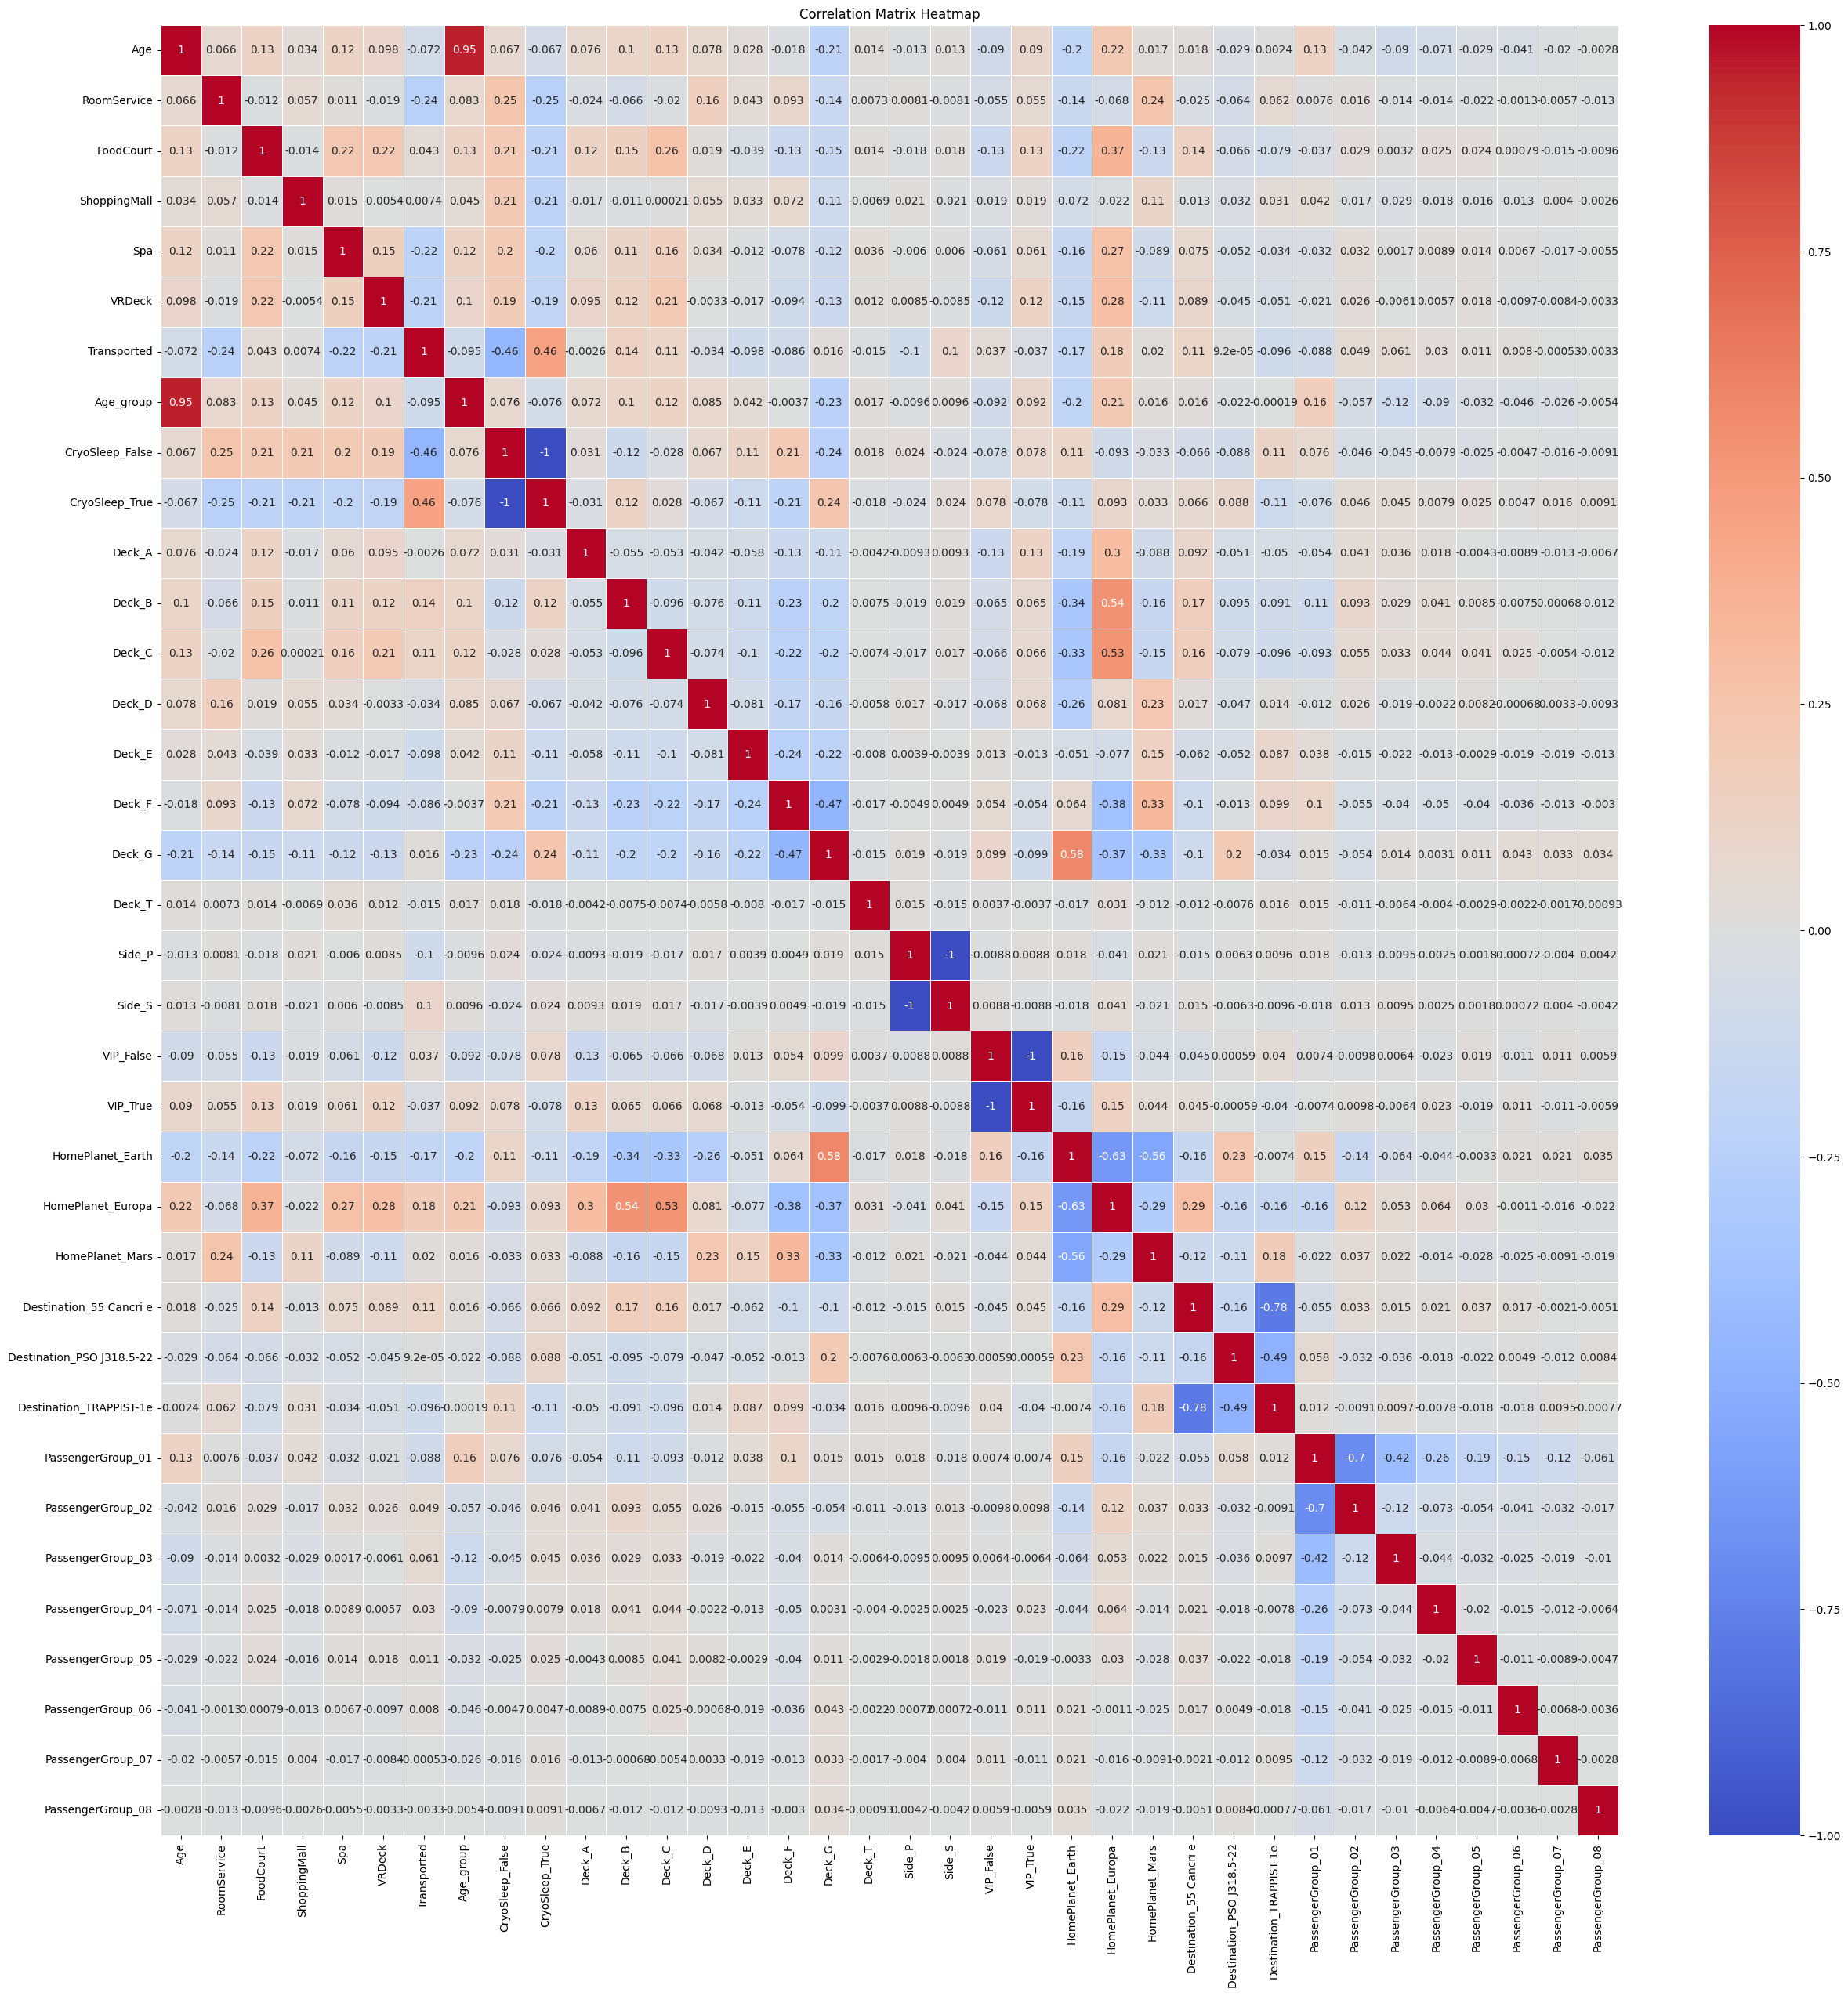

In [121]:
correlation_matrix = trainDF.corr()
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.savefig('correlation_heatmap.png')
plt.show()

In [122]:
def display_corr(df,col):
    top_corr = df.corr()[col].abs().sort_values(ascending=False)[1:21]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_corr.values, y=top_corr.index, orient='h')
    plt.xlabel('Absolute Correlation')
    plt.ylabel('Features')
    plt.title('Top Correlations with '+ col)
        plt.savefig('Correlations_with_Transported.png')
    plt.show()
    return top_corr

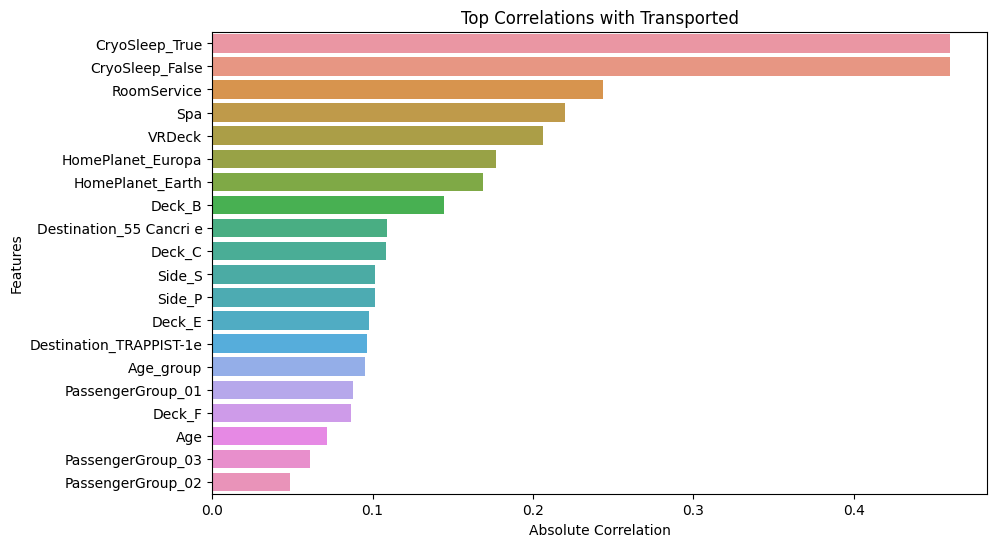

In [123]:
top_corr = display_corr(trainDF,'Transported')

In [14]:
top_corr.index

Index(['CryoSleep_True', 'CryoSleep_False', 'RoomService', 'Spa', 'VRDeck',
       'HomePlanet_Europa', 'HomePlanet_Earth', 'Deck_B',
       'Destination_55 Cancri e', 'Deck_C', 'Side_S', 'Side_P', 'Age_group',
       'Deck_E', 'Destination_TRAPPIST-1e', 'PassengerGroup_01', 'Deck_F',
       'Age', 'PassengerGroup_03', 'PassengerGroup_02'],
      dtype='object')

In [24]:
X = trainDF.drop(columns=["Transported"]).copy()
y = trainDF.Transported
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
model = LGBMClassifier()
model.fit(X, y)

result = permutation_importance(model, X_val, y_val, scoring="accuracy", n_repeats=100, random_state=42)
sorted_indices = np.argsort(result.importances_mean)[::-1]

top_features = X.columns[sorted_indices[:10]]
top_importances = result.importances_mean[sorted_indices[:10]]
for feature, importance in zip(top_features, top_importances):
    print(f"{feature}: {importance}")

CryoSleep_False: 0.11033352501437607
Spa: 0.055296147211040834
VRDeck: 0.05502587694077055
FoodCourt: 0.04362277170787807
RoomService: 0.03642898217366301
Age: 0.02514088556641748
ShoppingMall: 0.021621621621621623
Deck_C: 0.016733755031627363
Side_P: 0.016152961472110407
Deck_E: 0.010195514663599758


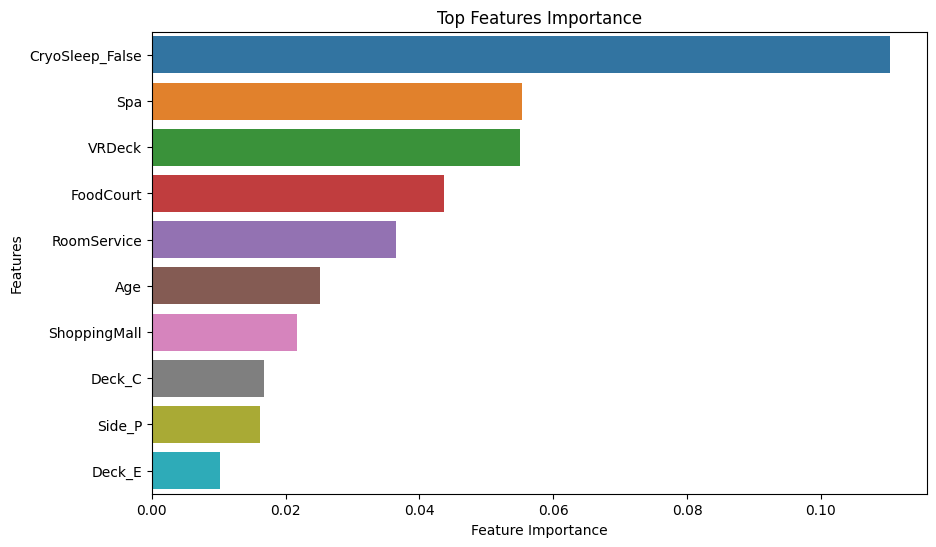

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_features, orient='h')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top Features')
plt.show()

In [10]:
def objective(trial):    
    params = {
      'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
      'max_depth': trial.suggest_int('max_depth', 3, 10),
      'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 1),
      'subsample': trial.suggest_uniform('subsample', 0.1, 1),
      'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1),
      'alpha': trial.suggest_loguniform('alpha', 2, 5),
      'lambda': trial.suggest_loguniform('lambda', 2, 5),
      'min_child_weight': trial.suggest_int('min_child_weight', 1, 300)
    }
    model = XGBClassifier(**params, random_state=42)
    score = cross_val_score(model, X, y, cv=5).mean()
    
    return score

In [31]:
X = trainDF[top_features]
y = trainDF.Transported

In [53]:
num_trials = 3
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=num_trials)

[I 2023-09-22 00:58:41,273] A new study created in memory with name: no-name-02af674c-e1f1-43b7-8669-b007beea14cb
/tmp/ipykernel_32/579772089.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 1),
/tmp/ipykernel_32/579772089.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 1),
/tmp/ipykernel_32/579772089.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1),
/

In [54]:
best_params = study.best_params
print(f'Best hyperparameters for {num_trials} trials: {best_params}')

Best hyperparameters for 3 trials: {'n_estimators': 540, 'max_depth': 4, 'learning_rate': 0.09624273404291919, 'subsample': 0.29444514475726846, 'colsample_bytree': 0.7946077090710533, 'alpha': 2.5308112907354197, 'lambda': 2.226243282386066, 'min_child_weight': 11}


In [43]:
best_params 

{'n_estimators': 324,
 'max_depth': 7,
 'learning_rate': 0.05082464957023218,
 'subsample': 0.7174633890765281,
 'colsample_bytree': 0.7327518616075124,
 'alpha': 2.4720836342902714,
 'lambda': 4.035352795773316,
 'min_child_weight': 6}

In [39]:
best_params = {'n_estimators': 324,
 'max_depth': 7,
 'learning_rate': 0.05082464957023218,
 'subsample': 0.7174633890765281,
 'colsample_bytree': 0.7327518616075124,
 'alpha': 2.4720836342902714,
 'lambda': 4.035352795773316,
 'min_child_weight': 6}

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state = 42) 

best_params = {'n_estimators': 239,
 'max_depth': 4,
 'learning_rate': 0.30098660438830793,
 'subsample': 0.45033762470704164,
 'colsample_bytree': 0.9194602116386734,
 'alpha': 3.790183562628731,
 'lambda': 4.4617755988814505,
 'min_child_weight': 9}

model = XGBClassifier(**best_params, random_state=0)

model.fit(X_train, y_train) 

y_pred = model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", confusion)

Accuracy: 0.7753067484662577
Precision: 0.7458333333333333
Recall: 0.8299845440494591
F1 Score: 0.7856620336503292
Confusion Matrix:
 [[474 183]
 [110 537]]


In [44]:
accuracy = 0
while(accuracy<0.78):
    num_trials = 3
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=num_trials)
    
    best_params = study.best_params
    print(f'Best hyperparameters for {num_trials} trials: {best_params}')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state = 42) 

    model = XGBClassifier(**best_params, random_state=0)

    model.fit(X_train, y_train) 

    y_pred = model.predict(X_test)


    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)


    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", confusion)

[I 2023-10-01 06:50:06,824] A new study created in memory with name: no-name-577adffa-2166-44d2-85a3-67e6725f4090
/tmp/ipykernel_32/579772089.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 1),
/tmp/ipykernel_32/579772089.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 1),
/tmp/ipykernel_32/579772089.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1),
/

Best hyperparameters for 3 trials: {'n_estimators': 853, 'max_depth': 6, 'learning_rate': 0.6586826781645122, 'subsample': 0.25380749692079335, 'colsample_bytree': 0.7207238993769232, 'alpha': 4.74388111659747, 'lambda': 2.453425472183284, 'min_child_weight': 42}


[I 2023-10-01 06:50:34,883] A new study created in memory with name: no-name-9754fce2-461f-443b-8e1d-414a350104a1


Accuracy: 0.7653374233128835
Precision: 0.7338820301783264
Recall: 0.8268933539412674
F1 Score: 0.7776162790697674
Confusion Matrix:
 [[463 194]
 [112 535]]


/tmp/ipykernel_32/579772089.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 1),
/tmp/ipykernel_32/579772089.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 1),
/tmp/ipykernel_32/579772089.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1),
/tmp/ipykernel_32/579772089.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature wil

Best hyperparameters for 3 trials: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.07469971533837927, 'subsample': 0.4655468513944713, 'colsample_bytree': 0.7854372084344001, 'alpha': 4.7654776300042085, 'lambda': 3.441981953242356, 'min_child_weight': 38}


[I 2023-10-01 06:50:58,216] A new study created in memory with name: no-name-6e403fcd-bd90-442c-b860-263991c2ef59


Accuracy: 0.7730061349693251
Precision: 0.7427385892116183
Recall: 0.8299845440494591
F1 Score: 0.7839416058394161
Confusion Matrix:
 [[471 186]
 [110 537]]


/tmp/ipykernel_32/579772089.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 1),
/tmp/ipykernel_32/579772089.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 1),
/tmp/ipykernel_32/579772089.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1),
/tmp/ipykernel_32/579772089.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature wil

Best hyperparameters for 3 trials: {'n_estimators': 176, 'max_depth': 8, 'learning_rate': 0.1560511033357882, 'subsample': 0.9832058202066252, 'colsample_bytree': 0.9156499573896728, 'alpha': 3.300956441974297, 'lambda': 4.141089004941626, 'min_child_weight': 82}
Accuracy: 0.7806748466257669
Precision: 0.7503467406380028
Recall: 0.8361669242658424
F1 Score: 0.7909356725146199
Confusion Matrix:
 [[477 180]
 [106 541]]


In [33]:
testDF = get_df(test_csv)
testDF = testDF[top_features]
testDF.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CryoSleep_False  4277 non-null   float64
 1   Spa              4277 non-null   float64
 2   VRDeck           4277 non-null   float64
 3   FoodCourt        4277 non-null   float64
 4   RoomService      4277 non-null   float64
 5   Age              4277 non-null   float64
 6   ShoppingMall     4277 non-null   float64
 7   Deck_C           4277 non-null   float64
 8   Side_P           4277 non-null   float64
 9   Deck_E           4277 non-null   float64
dtypes: float64(10)
memory usage: 334.3 KB


In [45]:
pred = model.predict(testDF)
sample_submission_df = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')
sample_submission_df['Transported'] = (pred  > 0.5).astype(bool)
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
